In [1]:
import statistics
import timeit
import itertools
import numpy as np
import torch
import torch.nn as nn
import optuna
import sklearn.metrics as skm
import torch
import importlib
import fastai
import tsai
import torch.nn.functional as F
import copy
import shap
importlib.reload(fastai)
importlib.reload(tsai)

from collections import Counter
from tsai.all import *
from tsai.data.validation import combine_split_data, get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.tslearner import TSClassifier
from optuna.samplers import TPESampler
from optuna.integration import FastAIPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import WeightedRandomSampler
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import BCEWithLogitsLossFlat, FocalLoss, FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

In [2]:
np.set_printoptions(precision=4,suppress = True)

In [3]:
import pgmpy

In [4]:
# Import the necessary modules
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


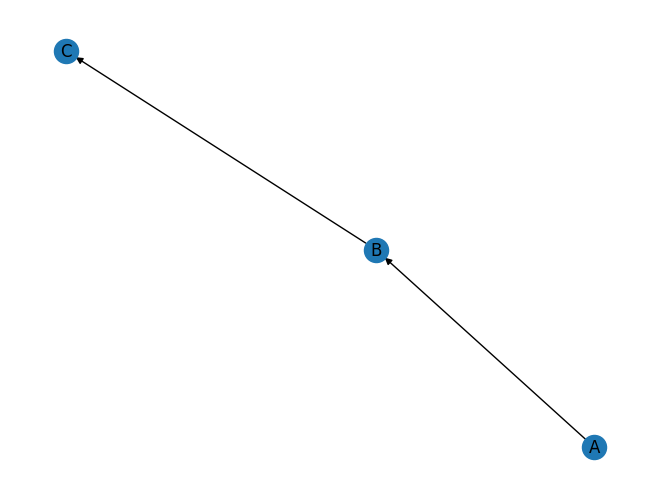

In [6]:
# Define the DAG
model = BayesianModel([('A', 'B'), ('B', 'C')])

# Define the conditional probability distributions (CPDs)
#cpd_a = TabularCPD('A', 2, [[0.3], [0.7]])
#cpd_b = TabularCPD('B', 2, [[0.6, 0.4], [0.3, 0.7]], evidence=['A'], evidence_card=[2])
#cpd_c = TabularCPD('C', 2, [[0.8, 0.2], [0.1, 0.9]], evidence=['B'], evidence_card=[2])

# Define the conditional probability distributions (CPDs)
#cpd_a = TabularCPD('A', 2, [[0.3], [0.7]])
#cpd_b = TabularCPD('B', 2, [[0.6, 0.4], [0.4, 0.6]], evidence=['A'], evidence_card=[2])
#cpd_c = TabularCPD('C', 2, [[0.8, 0.2], [0.1, 0.9]], evidence=['B'], evidence_card=[2])

# Define the conditional probability distributions (CPDs)
cpd_a = TabularCPD('A', 2, [[0.3], [0.7]])
cpd_b = TabularCPD('B', 2, [[0.6, 0.4], [0.4, 0.6]], evidence=['A'], evidence_card=[2])
cpd_c = TabularCPD('C', 2, [[0.8, 0.2], [0.2, 0.8]], evidence=['B'], evidence_card=[2])



# Add the CPDs to the model
model.add_cpds(cpd_a, cpd_b, cpd_c)

# Create a NetworkX graph from the BayesianModel
graph = nx.DiGraph(model.edges())

# Plot the DAG
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, arrows=True)
plt.show()

In [7]:
# Simulate data from the DAG
sampler = BayesianModelSampling(model)
sim_data = sampler.forward_sample(size=1000)

# View the simulated data
print(sim_data.head())


  0%|          | 0/3 [00:00<?, ?it/s]

   A  B  C
0  1  0  0
1  0  0  1
2  1  1  1
3  1  1  1
4  0  0  0


In [8]:
sim_data.shape

(1000, 3)

In [9]:
from pgmpy.models import DynamicBayesianNetwork
from pgmpy.factors.discrete import TabularCPD

In [18]:
# Define the temporal Bayesian network structure
model = DynamicBayesianNetwork()

# Add nodes for each time step
for t in range(10):
    model.add_node(('Variable', t))

# Add edges representing temporal dependencies
for t in range(9):
    model.add_edge(('Variable', t), ('Variable', t+1))

# Define conditional probability distributions (CPDs) for each variable
for t in range(10):
    cpd = TabularCPD(
        variable=('Variable', t),
        variable_card=2,  # Number of states for each variable (e.g., 2 for binary variables)
        values=[[0.7, 0.3],  # CPD values, modify according to your requirements
                [0.3, 0.7]]
    )
    model.add_cpds(cpd)

# Check model for correctness
model.check_model()


ValueError: values must be of shape (2, 1). Got shape: (2, 2)

In [35]:
# Define the temporal Bayesian network structure
model = DynamicBayesianNetwork()

# Define nodes (variables) in the temporal DAG
nodes = ['A', 'B', 'C', 'D']

# Add nodes to the model
model.add_nodes_from(nodes)

# Define the edges (causal relationships) in the temporal DAG
edges = [('A', 'B'), ('B', 'C'), ('C', 'D')]

# Add edges to the model
model.add_edges_from(edges)

# Define CPDs for each variable at each time step
cpd_A = TabularCPD(variable='A', variable_card=2, values=[[0.5], [0.5]])
cpd_B = TabularCPD(variable='B', variable_card=2, values=[[0.7, 0.3], [0.4, 0.6]], evidence=['A'], evidence_card=[2])
cpd_C = TabularCPD(variable='C', variable_card=2, values=[[0.8, 0.2], [0.1, 0.9]], evidence=['B'], evidence_card=[2])
cpd_D = TabularCPD(variable='D', variable_card=2, values=[[0.3, 0.7], [0.9, 0.1]], evidence=['C'], evidence_card=[2])

# Add CPDs to the model
model.add_cpds(cpd_A, cpd_B, cpd_C, cpd_D)


ValueError: Nodes must be of type (node, time_slice).

In [57]:
# Create an instance of DynamicBayesianNetwork
model = DynamicBayesianNetwork()

# Define nodes (variables) in the temporal causal network
nodes = [('A', 0), ('B', 0), ('C', 0), ('D', 0)]  # Replace with your variable names and time slices

# Add nodes to the model
model.add_nodes_from(nodes)

# Define edges in the temporal causal network
edges = [(('A', 0), ('B', 0)), (('B', 0), ('C', 0)), (('C', 0), ('D', 0))]  # Replace with your edges

# Add edges to the model
model.add_edges_from(edges)

# Define CPDs for each variable at each time step
cpd_A = TabularCPD(
    variable=('A', 0),
    variable_card=2,
    values=[[0.5], [0.5]]  # Replace with your CPD values
)
cpd_B = TabularCPD(variable=('B',0), variable_card=2, values=[[0.6, 0.4], [0.4, 0.6]], evidence=[('A',0)], evidence_card=[2])
cpd_C = TabularCPD(variable=('C',0), variable_card=2, values=[[0.8, 0.2], [0.2, 0.8]], evidence=[('B',0)], evidence_card=[2])
cpd_D = TabularCPD(variable=('D',0), variable_card=2, values=[[0.3, 0.7], [0.7, 0.3]], evidence=[('C',0)], evidence_card=[2])

cpd_A1 = TabularCPD(
    variable=('A', 1),
    variable_card=2,
    values=[[0.5], [0.5]]  # Replace with your CPD values
)
cpd_B1 = TabularCPD(variable=('B',1), variable_card=2, values=[[0.6, 0.4], [0.4, 0.6]], evidence=[('A',0)], evidence_card=[2])
cpd_C1 = TabularCPD(variable=('C',1), variable_card=2, values=[[0.8, 0.2], [0.2, 0.8]], evidence=[('B',0)], evidence_card=[2])
cpd_D1 = TabularCPD(variable=('D',1), variable_card=2, values=[[0.3, 0.7], [0.7, 0.3]], evidence=[('C',0)], evidence_card=[2])


# Add CPDs to the model
model.add_cpds(cpd_A, cpd_B, cpd_C, cpd_D,cpd_A1, cpd_B1, cpd_C1, cpd_D1)
#model.add_cpds(cpd_A)
#model.add_cpds(cpd_B)

# Print the model to verify the nodes, edges, and CPDs
print(model)

DynamicBayesianNetwork with 12 nodes and 6 edges


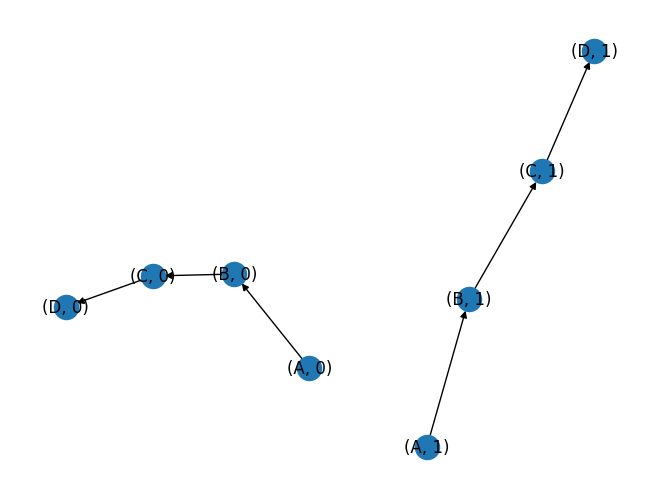

In [58]:
# Create a NetworkX graph from the BayesianModel
graph = nx.DiGraph(model.edges())

# Plot the DAG
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, arrows=True)
plt.show()

In [59]:
from pgmpy.sampling import BayesianModelSampling

In [60]:

# Create a BayesianModelSampling object and sample from the model
samples = model.simulate(n_time_slices=4, n_samples=2)

# View the simulated data
print(sim_data.head())

  0%|          | 0/32 [00:00<?, ?it/s]

ValueError: No CPD associated with A_0

In [34]:
import numpy as np
import pomegranate
from pomegranate import *
from pomegranate import BayesianNetwork

ImportError: cannot import name 'BayesianNetwork' from 'pomegranate' (/home/DIDE/smishra/miniconda3/envs/hfixed/lib/python3.9/site-packages/pomegranate/__init__.py)

In [33]:


# Define the structure of the temporal DAG
model = BayesianNetwork()

# Define nodes (variables) in the temporal DAG
nodes = [DiscreteDistribution({'A': 0.5, 'B': 0.5})]  # Initial distribution for t=0

for t in range(1, 10):
    node = ConditionalProbabilityTable([
        ['A', 'A', 0.7],
        ['A', 'B', 0.3],
        ['B', 'A', 0.4],
        ['B', 'B', 0.6],
    ], [nodes[t - 1]])

    nodes.append(node)

# Add nodes to the model
for node in nodes:
    model.add_node(node)

# Add edges between nodes
for t in range(1, 10):
    model.add_edge(nodes[t - 1], nodes[t])

# Bake the model
model.bake()

# Sample data from the temporal DAG
data = model.sample(1000)

# Print the sampled data
for t in range(10):
    print(f"Time {t}: {data[:, t].tolist()}")

NameError: name 'BayesianNetwork' is not defined

In [107]:
# load in arguments from command line
name = "SimpleData"
model_name="ResNet"
randnum_split=3
epochs=8
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5

In [263]:

X_raw = np.load("".join([filepath,"input_data_simple/",name, "_X.npy"])).astype(np.float32)


Y_raw = np.squeeze(np.load("".join([filepath,"input_data_simple/",name, "_YH.npy"])))
Y = Y_raw[:, np.shape(Y_raw)[1] - 1]


In [264]:
Y.shape

(100000,)

In [265]:
#X_raw, y_raw = Data_load.load_data(name=name,filepath=filepath)

## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=Y,randnum=randnum_split)

## Now scale all the data for ease (can fix this later)
#X_scaled=Data_load.prep_data(X_raw,splits)

#X_trainvalid_s, X_test_s=X_scaled[splits[0]], X_scaled[splits[1]]


Random state set:3, cuda used: True
Counter({0: 72143, 1: 27857}) Counter({0: 57714, 1: 22286}) Counter({0: 14429, 1: 5571})


In [266]:
# Give the architecture for each model
if model_name=="LSTMFCN":
    arch=LSTM_FCNPlus

if model_name=="TCN":
    arch=TCN

if model_name=="XCM":
    arch=XCMPlus

if model_name=="ResCNN":
    arch=ResCNN

if model_name=="ResNet":
    arch=ResNetPlus

if model_name=="InceptionTime":
    arch=InceptionTimePlus

if model_name=="MLSTMFCN":
    arch=MLSTM_FCNPlus


## Set seed
Data_load.random_seed(randnum_split)

## split out the test set
splits_9010 = get_splits(
        Y_trainvalid,
        valid_size=0.1,
        stratify=True,
        shuffle=True,
        test_size=0,
        show_plot=False,
        random_state=randnum_split
        )
Xtrainvalid90=X_trainvalid[splits_9010[0]]
Ytrainvalid90=Y_trainvalid[splits_9010[0]]
Xtrainvalid10=X_trainvalid[splits_9010[1]]
Ytrainvalid10=Y_trainvalid[splits_9010[1]]

randnum=1

Random state set:3, cuda used: True


In [267]:
def test_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    where1s=np.where(Y_test==1)
    where0s=np.where(Y_test==0)
    test_probasout=test_probas.numpy()
    test_probasout=test_probasout[:,1]
    print("Y equal 0:")
    print([min(test_probasout[where0s]),statistics.mean(test_probasout[where0s]),max(test_probasout[where0s])])
    print("Y equal 1:")
    print([min(test_probasout[where1s]),statistics.mean(test_probasout[where1s]),max(test_probasout[where1s])])

    ## get the various metrics for model fit
    acc=skm.accuracy_score(test_targets,test_preds)
    prec=skm.precision_score(test_targets,test_preds)
    rec=skm.recall_score(test_targets,test_preds)
    fone=skm.f1_score(test_targets,test_preds)
    auc=skm.roc_auc_score(test_targets,test_preds)
    prc=skm.average_precision_score(test_targets,test_preds)
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"f1: {fone:.4f}")
    print(f"auc: {auc:.4f}")
    print(f"prc: {prc:.4f}")

    return acc, prec, rec, fone, auc, prc

In [268]:

# loop for fitting model with generic/pre-specified hyperparameters
lr_max=1e-3
batch_size=128
alpha=0.5
gamma=2

colnames=["data","model","seed","epochs", "accuracy", "precision", "recall", "f1", "auc","prc", "time","lr_max","batch_size","alpha","gamma"]
output = pd.DataFrame(columns=colnames)

# Fitting the model on train/test with pre-selected hyperparameters
# define the metrics for model fitting output
metrics=[accuracy,F1Score(),RocAucBinary(),BrierScore()]
weights=torch.tensor([alpha,1-alpha], dtype=torch.float).to(device)

ESPatience=2

# prep the data for the model
tfms=[None,[Categorize()]]
dsets = TSDatasets(X_trainvalid, Y_trainvalid, tfms=tfms, splits=splits_9010,inplace=True)

dls=TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=batch_size,
    num_workers=0,
    device=device
    )

for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

print(dls.c)
print(dls.len)
print(dls.vars)


TensorCategory(0.2812, device='cuda:1')
TensorCategory(0.2500, device='cuda:1')
TensorCategory(0.2734, device='cuda:1')
TensorCategory(0.2812, device='cuda:1')
TensorCategory(0.2734, device='cuda:1')
TensorCategory(0.2969, device='cuda:1')
TensorCategory(0.2891, device='cuda:1')
TensorCategory(0.2422, device='cuda:1')
TensorCategory(0.3125, device='cuda:1')
TensorCategory(0.2656, device='cuda:1')
2
2
2


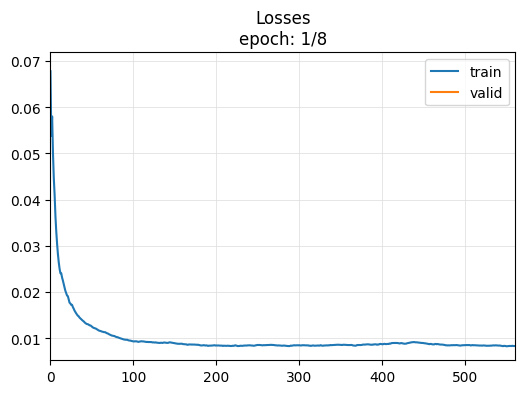

Epoch 2: reducing lr to 9.332460975408903e-05
Epoch 4: reducing lr to 5.004708820169149e-05
Epoch 5: reducing lr to 2.504110471439765e-05
No improvement since epoch 3: early stopping


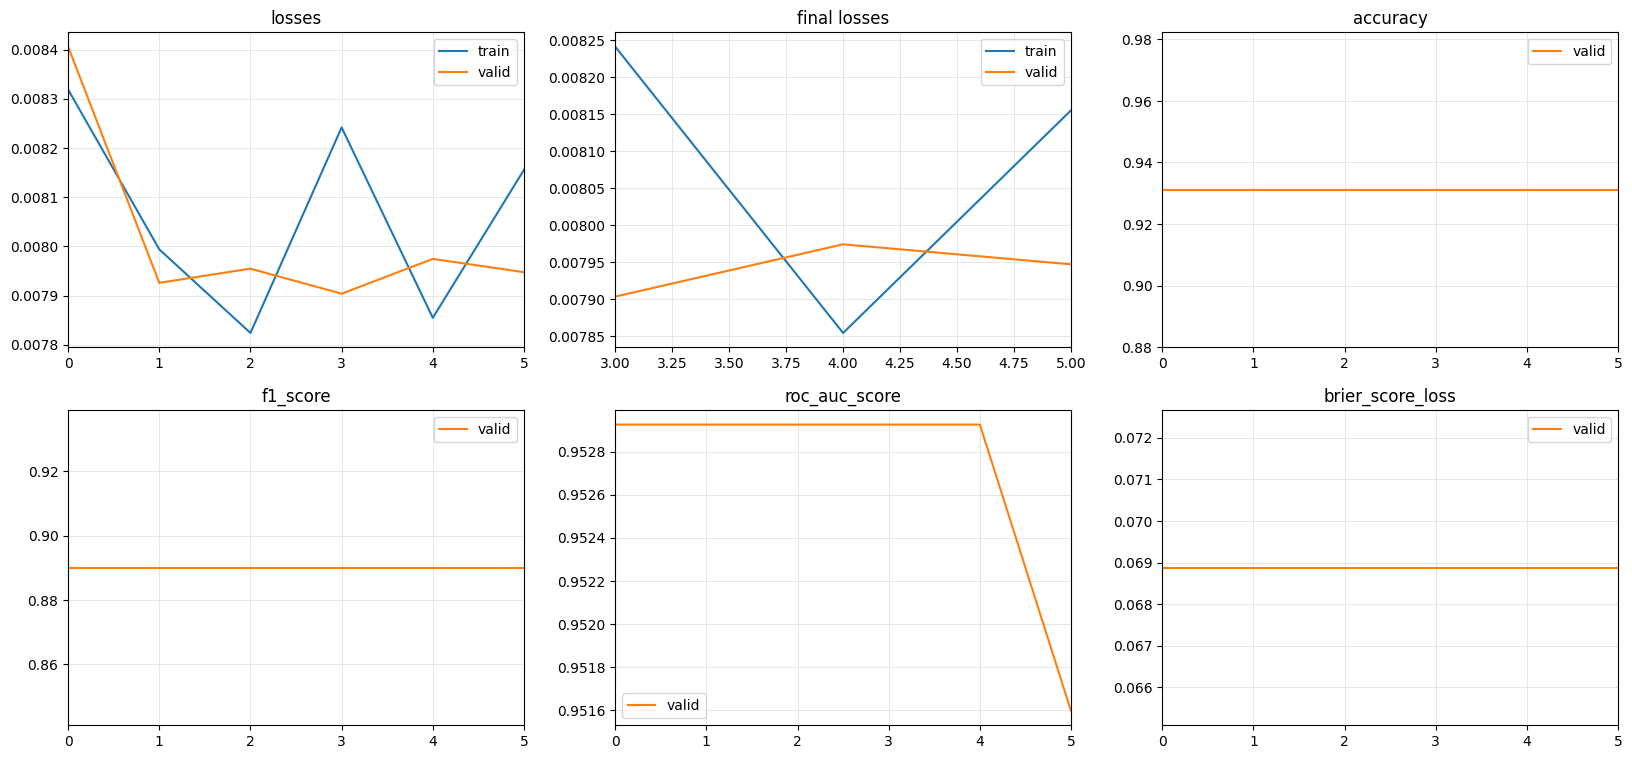

Y equal 0:
[0.003025904, 0.060645245, 0.5892879]
Y equal 1:
[0.5851638, 0.5872018, 0.5892879]
accuracy: 0.9292
precision: 0.7972
recall: 1.0000
f1: 0.8872
auc: 0.9509
prc: 0.7972
Y 0, predicted 0 (true negatives)        13012.000000
Y 0, predicted 1 (false positives)       1417.000000
Y 1, predicted 0 (false negatives)       0.000000
Y 1, predicted 1 (true positives)        5571.000000


(0.92915,
 0.7972238122495707,
 1.0,
 0.8871725455848396,
 0.950897498094116,
 0.7972238122495707,
 13012,
 1417,
 0,
 5571)

In [269]:
Data_load.random_seed2(randnum,dls=dls)

model = arch(dls.vars, dls.c,dls.len)

model.to(device)

learn = Learner(
    dls, 
    model, 
    metrics=metrics,
    loss_func=FocalLossFlat(gamma=torch.tensor(gamma).to(device),weight=weights),
    cbs=[EarlyStoppingCallback(patience=ESPatience),ReduceLROnPlateau(),ShowGraph()]
    )

learn.fit_one_cycle(epochs, lr_max)

MLmodel_opt_learner.test_results(learn,X_test,Y_test)


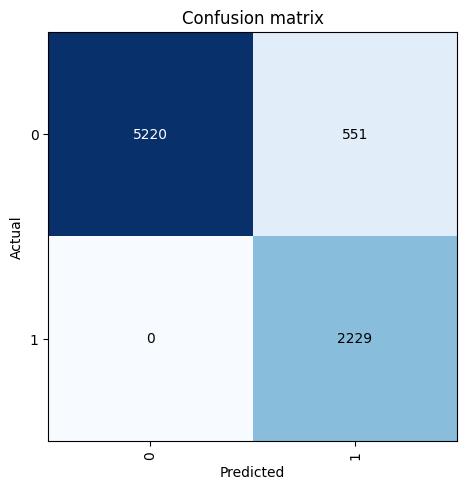

In [270]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [271]:
batch = dls.one_batch()
num_samples = 95

In [272]:
explainer = shap.GradientExplainer(
    learn.model.cpu(), torch.tensor(batch[0][:num_samples]).cpu()
)

# calculate shapely values
shap_values, indices = explainer.shap_values(
    torch.tensor(batch[0][num_samples:]).cpu(),
    ranked_outputs=2
)
print(shap_values)

[array([[[ 0.126 ,  0.1284],
        [ 0.6465,  0.6558]],

       [[ 0.0849,  0.1586],
        [ 0.4594,  0.4103]],

       [[ 0.2004,  0.2575],
        [ 0.5413,  0.4823]],

       [[ 0.2637,  0.2467],
        [ 0.6445,  0.6557]],

       [[ 0.0777,  0.1628],
        [ 0.4765,  0.4083]],

       [[-0.0208, -0.052 ],
        [ 0.4634,  0.4046]],

       [[ 0.3214,  0.2377],
        [ 0.5212,  0.4668]],

       [[ 0.1612,  0.1993],
        [ 0.3723,  0.3368]],

       [[ 0.174 ,  0.1866],
        [ 0.9036,  0.8827]],

       [[-0.0793, -0.0864],
        [ 0.6331,  0.5369]],

       [[ 0.2304,  0.2209],
        [ 0.8875,  0.8823]],

       [[ 0.212 ,  0.2042],
        [ 0.526 ,  0.5455]],

       [[ 0.2018,  0.2036],
        [ 0.7329,  0.7183]],

       [[ 0.2094,  0.2121],
        [ 0.6522,  0.6703]],

       [[ 0.001 , -0.0361],
        [ 0.6956,  0.6055]],

       [[ 0.2041,  0.2063],
        [ 0.6787,  0.658 ]],

       [[ 0.0437,  0.1082],
        [ 0.496 ,  0.4559]],

       [[-0.0

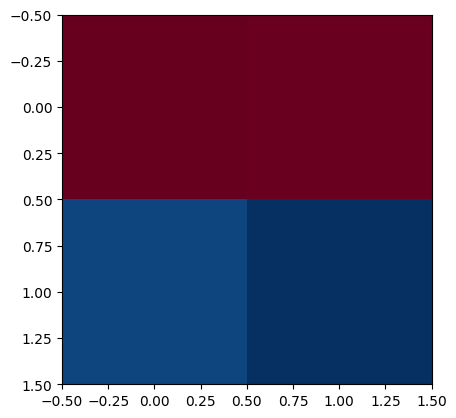

In [273]:
import matplotlib.pyplot as plt
import numpy as np
shap_out=shap_values[0]
plot_shap=shap_out[13,:,:]
plot_shap_scaled=np.log((plot_shap-plot_shap.min())/(plot_shap.max()-plot_shap.min()+1e-8))
plt.imshow(plot_shap, cmap='RdBu', interpolation='nearest')
plt.show()

In [274]:
import seaborn as sns

<Axes: >

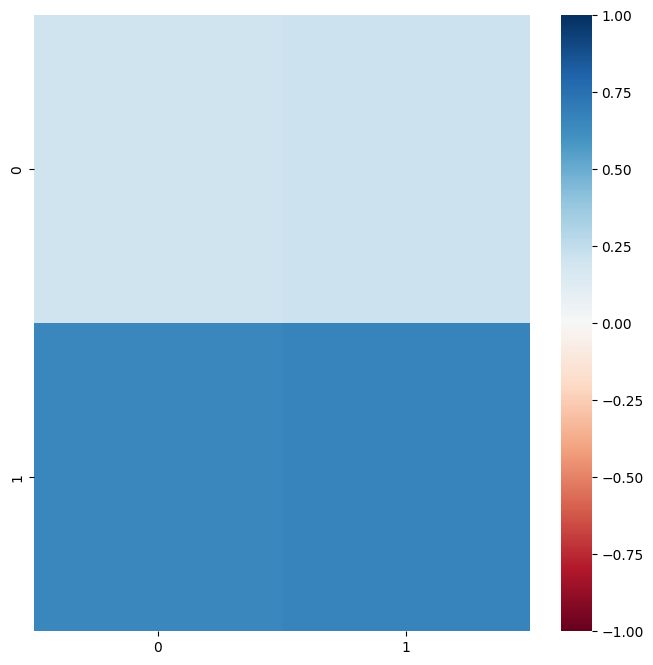

In [275]:
plt.figure(figsize=(8,8))
sns.heatmap(data=plot_shap, cmap='RdBu',vmin=-1,center=0,vmax=1)

<Axes: >

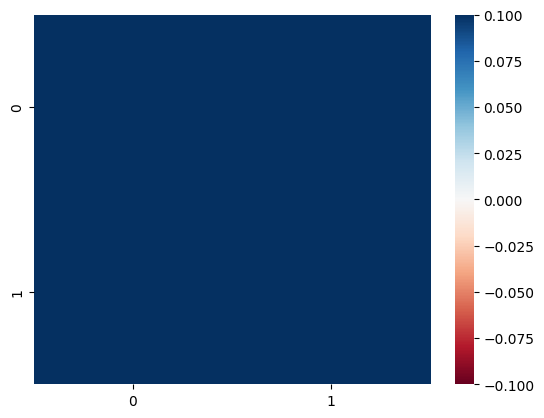

In [276]:
sns.heatmap(data=plot_shap, cmap='RdBu',vmin=-0.1,center=0,vmax=0.1)

In [277]:
neg_idx = np.where(np.array(batch[1][num_samples:].cpu())==0)
pos_idx = np.where(np.array(batch[1][num_samples:].cpu())==1)

In [278]:
little_check=batch[0][num_samples:]

pos_shap=shap_out[pos_idx,:,:]
neg_shap=shap_out[neg_idx,:,:]
pos_shap=pos_shap[0,:,:,:]
neg_shap=neg_shap[0,:,:,:]
pos_base=little_check[pos_idx,:,:]
neg_base=little_check[neg_idx,:,:]
pos_base=pos_base[0,:,:,:]
neg_base=neg_base[0,:,:,:]
pos_base=np.array(pos_base.cpu())
neg_base=np.array(neg_base.cpu())

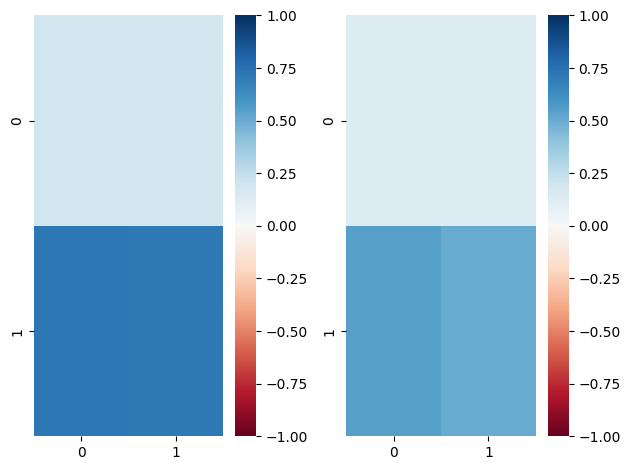

In [279]:
fig,axes = plt.subplots(1,2)
sns.heatmap(data=pos_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[0])
sns.heatmap(data=neg_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[1])
fig.tight_layout()

In [280]:
batch[1][num_samples:]

TensorCategory([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
                1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:1')

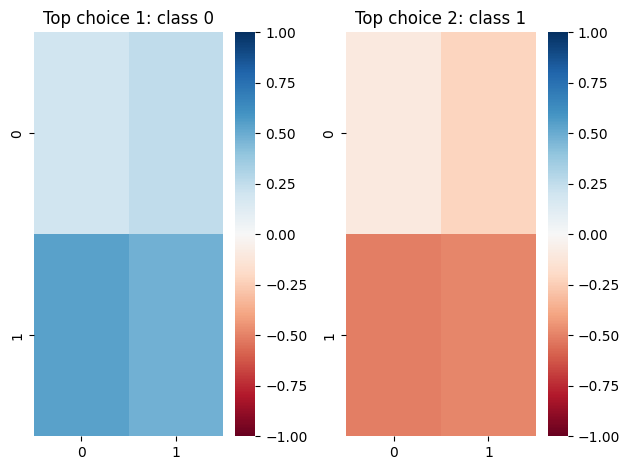

In [281]:
shap_num=2
fig,axes = plt.subplots(1,2)
sns.heatmap(data=shap_values[0][shap_num,:,:], cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[0])
sns.heatmap(data=shap_values[1][shap_num,:,:], cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[1])
axes[0].set_title(f'Top choice 1: class {indices[shap_num, 0]}')
axes[1].set_title(f'Top choice 2: class {indices[shap_num, 1]}')
fig.tight_layout()

In [282]:
shap_values[0][shap_num,:,:]

array([[0.2004, 0.2575],
       [0.5413, 0.4823]])

In [283]:
shap_values[1][shap_num,:,:]

array([[-0.0952, -0.2192],
       [-0.515 , -0.4917]])